In [2]:
from itertools import product
import copy
import random
import pickle

import nasim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import csv
import yaml
from yaml.loader import SafeLoader, BaseLoader, FullLoader, UnsafeLoader

%matplotlib inline

ModuleNotFoundError: No module named 'pandas'

# Agent definition

In [16]:
from gym import error
from pprint import pprint

try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import torch.nn.functional as F
    from torch.utils.tensorboard import SummaryWriter
except ImportError as e:
    raise error.DependencyNotInstalled(
        f"{e}. (HINT: you can install dqn_agent dependencies by running "
        "'pip install nasim[dqn]'.)"
    )


class ReplayMemoryDQN:

    def __init__(self, capacity, s_dims, device):
        self.capacity = capacity
        self.device = device
        self.s_buf = np.zeros((capacity, *s_dims), dtype=np.float32)
        self.a_buf = np.zeros((capacity, 1), dtype=np.int64)
        self.next_s_buf = np.zeros((capacity, *s_dims), dtype=np.float32)
        self.r_buf = np.zeros(capacity, dtype=np.float32)
        self.done_buf = np.zeros(capacity, dtype=np.float32)
        self.ptr, self.size = 0, 0

    def store(self, s, a, next_s, r, done):
        self.s_buf[self.ptr] = s
        self.a_buf[self.ptr] = a
        self.next_s_buf[self.ptr] = next_s
        self.r_buf[self.ptr] = r
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size+1, self.capacity)

    def sample_batch(self, batch_size):
        sample_idxs = np.random.choice(self.size, batch_size)
        batch = [self.s_buf[sample_idxs],
                 self.a_buf[sample_idxs],
                 self.next_s_buf[sample_idxs],
                 self.r_buf[sample_idxs],
                 self.done_buf[sample_idxs]]
        return [torch.from_numpy(buf).to(self.device) for buf in batch]


class DQN(nn.Module):
    """A simple Deep Q-Network """

    def __init__(self, input_dim, layers, num_actions):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(input_dim[0], layers[0])])
        for l in range(1, len(layers)):
            self.layers.append(nn.Linear(layers[l-1], layers[l]))
        self.out = nn.Linear(layers[-1], num_actions)

    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
        x = self.out(x)
        return x

    def save_DQN(self, file_path):
        torch.save(self.state_dict(), file_path)

    def load_DQN(self, file_path):
        self.load_state_dict(torch.load(file_path))

    def get_action(self, x):
        with torch.no_grad():
            if len(x.shape) == 1:
                x = x.view(1, -1)
            return self.forward(x).max(1)[1]


class DQNAgent:
    """A simple Deep Q-Network Agent """

    def __init__(self,
                 env,
                 seed=None,
                 lr=0.001,
                 training_steps=20000,
                 batch_size=32,
                 replay_size=10000,
                 final_epsilon=0.05,
                 exploration_steps=10000,
                 gamma=0.99,
                 hidden_sizes=[64, 64],
                 target_update_freq=1000,
                 verbose=True,
                 **kwargs):

        # This DQN implementation only works for flat actions
        assert env.flat_actions
        self.verbose = verbose
        if self.verbose:
            print(f"\nRunning DQN with config:")
            pprint(locals())

        # set seeds
        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed)

        # envirnment setup
        self.env = env

        self.num_actions = self.env.action_space.n
        self.obs_dim = self.env.observation_space.shape

        # logger setup
        self.logger = SummaryWriter()

        # Training related attributes
        self.lr = lr
        self.exploration_steps = exploration_steps
        self.final_epsilon = final_epsilon
        self.epsilon_schedule = np.linspace(1.0,
                                            self.final_epsilon,
                                            self.exploration_steps)
        self.batch_size = batch_size
        self.discount = gamma
        self.steps_done = 0

        # Neural Network related attributes
        self.device = torch.device("cuda"
                                   if torch.cuda.is_available()
                                   else "cpu")
        self.dqn = DQN(self.obs_dim,
                       hidden_sizes,
                       self.num_actions).to(self.device)
        if self.verbose:
            print(f"\nUsing Neural Network running on device={self.device}:")
            print(self.dqn)

        self.target_dqn = DQN(self.obs_dim,
                              hidden_sizes,
                              self.num_actions).to(self.device)
        self.target_update_freq = target_update_freq

        self.optimizer = optim.Adam(self.dqn.parameters(), lr=self.lr)
        self.loss_fn = nn.SmoothL1Loss()

        # replay setup
        self.replay = ReplayMemoryDQN(replay_size, self.obs_dim, self.device)

    def save(self, save_path):
        self.dqn.save_DQN(save_path)

    def load(self, load_path):
        self.dqn.load_DQN(load_path)

    def get_epsilon(self):
        if self.steps_done < self.exploration_steps:
            return self.epsilon_schedule[self.steps_done]
        return self.final_epsilon

    def get_egreedy_action(self, o, epsilon):
        if random.random() > epsilon:
            o = torch.from_numpy(o).float().to(self.device)
            return self.dqn.get_action(o).cpu().item()
        return random.randint(0, self.num_actions-1)

    def optimize(self):
        batch = self.replay.sample_batch(self.batch_size)
        s_batch, a_batch, next_s_batch, r_batch, d_batch = batch

        # get q_vals for each state and the action performed in that state
        q_vals_raw = self.dqn(s_batch)
        q_vals = q_vals_raw.gather(1, a_batch).squeeze()

        # get target q val = max val of next state
        with torch.no_grad():
            target_q_val_raw = self.target_dqn(next_s_batch)
            target_q_val = target_q_val_raw.max(1)[0]
            target = r_batch + self.discount*(1-d_batch)*target_q_val

        # calculate loss
        loss = self.loss_fn(q_vals, target)

        # optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.steps_done % self.target_update_freq == 0:
            self.target_dqn.load_state_dict(self.dqn.state_dict())

        q_vals_max = q_vals_raw.max(1)[0]
        mean_v = q_vals_max.mean().item()
        return loss.item(), mean_v

    
    # method for training agent (runs train episodes) !!!
    def train(self, max_episodes):

        num_episodes = 0
        
        ep_return_list = []
        ep_steps_list = []
        ep_action_list = []
        
        eval_perf_list = []
        eval_step_list = []
        eval_action_list = []
        eval_info_list = []
        
        while num_episodes < max_episodes:
            
            ep_results = self.run_train_episode()
            
            ep_return, ep_steps, ep_actions, goal = ep_results
            
            ep_return_list.append(ep_return)
            ep_steps_list.append(ep_steps)
            ep_action_list.append(ep_actions)
            
            eval_perfs, eval_steps, eval_actions, eval_infos = self.run_eval_episode()
            
            eval_perf_list.append(eval_perfs)
            eval_step_list.append(eval_steps)
            eval_action_list.append(eval_actions)
            eval_info_list.append(eval_infos)
            
            num_episodes += 1
            
            if num_episodes % 10 == 0 and self.verbose:
                print(f"\nEpisode {num_episodes}:")
                print(f"\treturn = {ep_return}")
                print(f"\tgoal = {goal}")
        
        return ep_return_list, ep_steps_list, ep_action_list, eval_perf_list, eval_step_list, eval_action_list, eval_info_list

    
    # method for running training episode !!!
    def run_train_episode(self):
        
        o = self.env.reset()
        done = False
        episode_return = 0
        steps = 0
        actions = []
        
        while not done:
            
            a = self.get_egreedy_action(o, self.get_epsilon())

            actions.append(a)
            
            next_o, r, done, step_limit_reached, info = self.env.step(a)
            
            self.replay.store(o, a, next_o, r, done)
            self.steps_done += 1
            steps += 1
            
            loss, mean_v = self.optimize()

            o = next_o
            episode_return += r
            
            if step_limit_reached:
                done = True

        return episode_return, steps, actions, self.env.goal_reached()

    
    # method for running evaluation epsiode !!!
    def run_eval_episode(self,
                         env=None,
                         eval_epsilon=0.05):
        if env is None:
            env = self.env
        o = self.env.reset()
        done = False

        steps = 0
        episode_return = 0

        a_list = []
        info_list = []
            
        while not done:
            
            a = self.get_egreedy_action(o, eval_epsilon)
            
            next_o, r, done, step_limit_reached, info = env.step(a)
            
            a_list.append(a)
            info_list.append(info)
            
            o = next_o
            episode_return += r
            steps += 1
            
            if step_limit_reached:
                done = True

        return episode_return, steps, a_list, info_list

# Environment, agent intialization

In [62]:
config_file = 'tiny.yaml'
env = nasim.load(config_file)
ag = DQNAgent(env, exploration_steps=10000)


Running DQN with config:
{'batch_size': 32,
 'env': <nasim.envs.environment.NASimEnv object at 0x2b276f490>,
 'exploration_steps': 10000,
 'final_epsilon': 0.05,
 'gamma': 0.99,
 'hidden_sizes': [64, 64],
 'kwargs': {},
 'lr': 0.001,
 'replay_size': 10000,
 'seed': None,
 'self': <__main__.DQNAgent object at 0x164880c40>,
 'target_update_freq': 1000,
 'training_steps': 20000,
 'verbose': True}

Using Neural Network running on device=cpu:
DQN(
  (layers): ModuleList(
    (0): Linear(in_features=56, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
  )
  (out): Linear(in_features=64, out_features=18, bias=True)
)


# Agent training

In [63]:
outputs_from_training = ag.train(250)


Episode 10:
	return = 20.0
	goal = True

Episode 20:
	return = 74.0
	goal = True

Episode 30:
	return = 22.0
	goal = True

Episode 40:
	return = 20.0
	goal = True

Episode 50:
	return = 16.0
	goal = True

Episode 60:
	return = 145.0
	goal = True

Episode 70:
	return = 1.0
	goal = True

Episode 80:
	return = 151.0
	goal = True

Episode 90:
	return = 148.0
	goal = True

Episode 100:
	return = 165.0
	goal = True

Episode 110:
	return = 186.0
	goal = True

Episode 120:
	return = 179.0
	goal = True

Episode 130:
	return = 178.0
	goal = True

Episode 140:
	return = 103.0
	goal = True

Episode 150:
	return = 56.0
	goal = True

Episode 160:
	return = 133.0
	goal = True

Episode 170:
	return = 176.0
	goal = True

Episode 180:
	return = 133.0
	goal = True

Episode 190:
	return = 192.0
	goal = True

Episode 200:
	return = 84.0
	goal = True

Episode 210:
	return = 185.0
	goal = True

Episode 220:
	return = 186.0
	goal = True

Episode 230:
	return = 189.0
	goal = True

Episode 240:
	return = 189.0

# Unpack training results

In [64]:
ep_return_list = outputs_from_training[0]
ep_steps_list = outputs_from_training[1]
ep_action_list = outputs_from_training[2]
eval_perf_list = outputs_from_training[3]
eval_step_list = outputs_from_training[4]
eval_action_list = outputs_from_training[5]
eval_info_list = outputs_from_training[6]

In [65]:
len(ep_return_list)

250

# Plotting training results

In [67]:
def rollavg_cumsum(a,n):
    assert n%2==1 
    cumsum_vec = np.cumsum(np.insert(a, 0, 0)) 
    return (cumsum_vec[n:] - cumsum_vec[:-n]) / n

In [68]:
def plot_training_rewards(ep_return_list, eval_perf_list, max_ep):
    print(len(ep_return_list))
    ep_return_rolling = rollavg_cumsum(ep_return_list, 5)
    eval_return_rolling = rollavg_cumsum(eval_perf_list, 15)
    print(len(ep_return_rolling))
    plt.scatter(np.arange(len(ep_return_rolling)), ep_return_rolling, c='red', s=1, alpha=0.5)
    plt.plot(np.arange(len(eval_return_rolling)), eval_return_rolling, c='blue')
    plt.xlim([0, max_ep])
    
    plt.show()

250
246


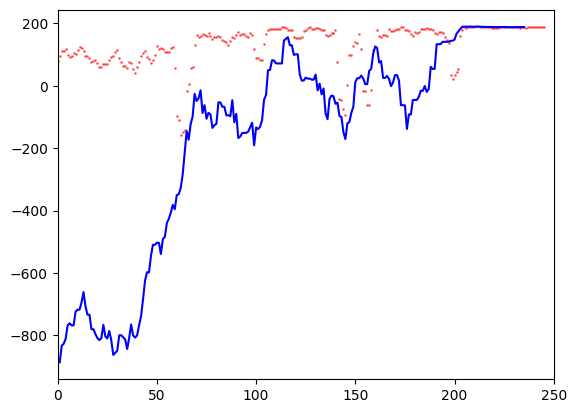

In [69]:
plot_training_rewards(ep_return_list, eval_perf_list, 250)

# Evaluation of agent

In [70]:
# Run the agent for 10 rounds, collect results
# Returns of run_eval_episode(): episode_return, steps, a_list, info_list

# stores
episode_return_list, steps_list, a_list_list, info_list_list = [], [], [], []

# for 10 episodes
for i in range(10):
    
    # evaluate
    a, b, c, d = ag.run_eval_episode()
    
    # store
    episode_return_list.append(a)
    steps_list.append(b)
    a_list_list.append(c)
    info_list_list.append(d)

In [73]:
print(episode_return_list)
print(steps_list)

[189.0, 191.0, 190.0, 191.0, 191.0, 190.0, 190.0, 190.0, 191.0, 186.0]
[11, 9, 10, 9, 9, 10, 10, 10, 9, 14]


In [77]:
names, targets = [], []

for i in range(len(a_list_list)):
    for j in range(len(a_list_list[i])):
        
        names.append(ag.env.action_space.get_action(a_list_list[i][j]).name)
        targets.append(ag.env.action_space.get_action(a_list_list[i][j]).target)
        
targets = [str(a) for a in targets]

In [81]:
print(targets[0:5])
print(names[0:5])

['(1, 0)', '(3, 0)', '(1, 0)', '(1, 0)', '(2, 0)']
['e_ssh', 'e_ssh', 'e_ssh', 'subnet_scan', 'e_ssh']


# Investigating states, actions

In [87]:
def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys(), fontsize=12)

In [82]:
# get x axis labels by looking at unique action names (if multiple agents, need to concatenate their actions first)
xticklabels = np.unique(names)
print(xticklabels)

['e_ssh' 'os_scan' 'pe_tomcat' 'subnet_scan']


In [84]:
# get the action counts for the unique actions (for each agent if multiple agents)
print(np.unique(names, return_counts=True))

(array(['e_ssh', 'os_scan', 'pe_tomcat', 'subnet_scan'], dtype='<U11'), array([49,  1, 20, 31]))


In [91]:
# there should be an entry for each agent with counts correponding to action count
data = {'ag': [49, 1, 20, 31]}

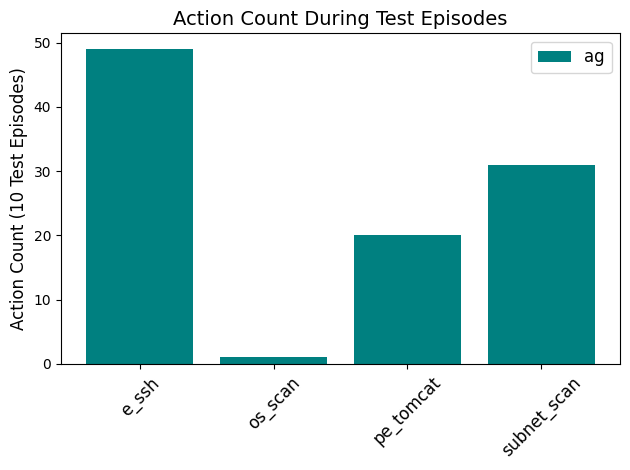

In [90]:
fig, ax = plt.subplots()
bar_plot(ax, data, colors=['teal'], total_width=0.8, single_width=1, legend=True)
plt.xticks(range(len(xticklabels)), xticklabels, rotation=45, fontsize=12)
plt.ylabel('Action Count (10 Test Episodes)')
plt.title('Action Count During Test Episodes')
ax.title.set_fontsize(14)
ax.yaxis.label.set_fontsize(12)
plt.tight_layout()
#plt.savefig('actions.png', dpi=400)
plt.show()